In [1]:
!wget https://bit.ly/fruits_300_data -O fruits_300.npy

--2021-06-19 03:49:15--  https://bit.ly/fruits_300_data
Resolving bit.ly (bit.ly)... 67.199.248.10, 67.199.248.11
Connecting to bit.ly (bit.ly)|67.199.248.10|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://github.com/rickiepark/hg-mldl/raw/master/fruits_300.npy [following]
--2021-06-19 03:49:15--  https://github.com/rickiepark/hg-mldl/raw/master/fruits_300.npy
Resolving github.com (github.com)... 13.114.40.48
Connecting to github.com (github.com)|13.114.40.48|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/rickiepark/hg-mldl/master/fruits_300.npy [following]
--2021-06-19 03:49:16--  https://raw.githubusercontent.com/rickiepark/hg-mldl/master/fruits_300.npy
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... conne

In [2]:
import numpy as np

fruits = np.load('fruits_300.npy')
fruits_2d = fruits.reshape(-1,100*100)

In [3]:
from sklearn.decomposition import PCA

pca = PCA(n_components= 50)
pca.fit(fruits_2d)

PCA(copy=True, iterated_power='auto', n_components=50, random_state=None,
    svd_solver='auto', tol=0.0, whiten=False)

In [4]:
print(pca.components_.shape)

(50, 10000)


In [5]:
import matplotlib.pyplot as plt

def draw_fruits(arr, ratio=1):
    n = len(arr)    # n은 샘플 개수입니다
    # 한 줄에 10개씩 이미지를 그립니다. 샘플 개수를 10으로 나누어 전체 행 개수를 계산합니다. 
    rows = int(np.ceil(n/10))
    # 행이 1개 이면 열 개수는 샘플 개수입니다. 그렇지 않으면 10개입니다.
    cols = n if rows < 2 else 10
    fig, axs = plt.subplots(rows, cols, 
                            figsize=(cols*ratio, rows*ratio), squeeze=False)
    for i in range(rows):
        for j in range(cols):
            if i*10 + j < n:    # n 개까지만 그립니다.
                axs[i, j].imshow(arr[i*10 + j], cmap='gray_r')
            axs[i, j].axis('off')
    plt.show()

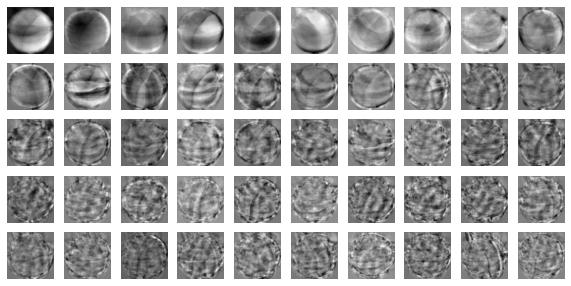

In [6]:
draw_fruits(pca.components_.reshape(-1,100,100))

In [7]:
print(fruits_2d.shape)

(300, 10000)


In [8]:
fruits_pca = pca.transform(fruits_2d)
print(fruits_pca.shape)

(300, 50)


# 재구성

In [9]:
fruits_inverse = pca.inverse_transform(fruits_pca)
print(fruits_inverse.shape)

(300, 10000)


In [10]:
fruits_reconstruct = fruits_inverse.reshape(-1, 100,100)

In [11]:
print(np.sum(pca.explained_variance_ratio_))

0.9215526199053982


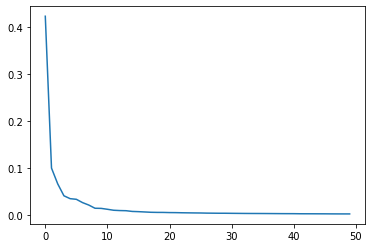

In [12]:
plt.plot(pca.explained_variance_ratio_)

# 분류기와 함께 사용하기

In [18]:
from sklearn.linear_model import LogisticRegression

lr = LogisticRegression()

In [19]:
target = np.array([0] * 100 + [1] * 100 + [2] * 100)

In [20]:

from sklearn.model_selection import cross_validate

scores = cross_validate(lr, fruits_2d, target)
print(np.mean(scores['test_score']))
print(np.mean(scores['fit_time']))

0.9966666666666667
1.5662326335906982


In [21]:
scores = cross_validate(lr, fruits_pca, target)
print(np.mean(scores['test_score']))
print(np.mean(scores['fit_time']))

1.0
0.02641429901123047


In [22]:
pca = PCA(n_components=0.5)
# 50% 만 설명하면 된다.
pca.fit(fruits_2d)
print(pca.n_components_)

2


In [23]:
fruits_pca = pca.transform(fruits_2d)
print(fruits_pca.shape)

(300, 2)


In [24]:
scores = cross_validate(lr, fruits_pca, target)
print(np.mean(scores['test_score']))
print(np.mean(scores['fit_time']))

0.9933333333333334
0.04608478546142578


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression


# 군집과 함께 사용하기

In [26]:
from sklearn.cluster import KMeans
km = KMeans(n_clusters=3, random_state=42)
km.fit(fruits_pca)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
       n_clusters=3, n_init=10, n_jobs=None, precompute_distances='auto',
       random_state=42, tol=0.0001, verbose=0)

In [28]:
print(np.unique(km.labels_, return_counts=True))

(array([0, 1, 2], dtype=int32), array([ 91,  99, 110]))


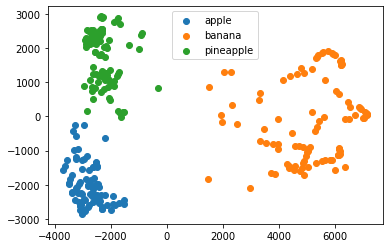

In [29]:
for label in range(0,3):
    data = fruits_pca[km.labels_ ==label]
    plt.scatter(data[:,0] , data[:,1])
plt.legend(['apple', 'banana', 'pineapple'])
plt.show()